***CYBERBULLING SENTIMENT ANALYSIS***

*ABOUT THE DATASET*

Context.

This dataset is one out of 8 collection of datasets from different sources related to the automatic detection of cyber-bullying.
The data is from different social media platforms like Kaggle, Twitter, Wikipedia Talk pages and YouTube.


Content.
The data contains different types of cyber-bullying, on this case we are going to analyze toxicity.
The data contain text and labeled as bullying or not.




the previous information about the dataset was taken from the dataset website source: https://www.kaggle.com/datasets/saurabhshahane/cyberbullying-dataset?resource=download, and adapted to our project proposal.

In [6]:
!pip install kaggle emoji ekphrasis

In [7]:
#Import libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from collections import Counter
import matplotlib.pyplot as plt
import emoji
from emoji import demojize
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
"""from google.colab import drive
drive.mount('/content/drive')
"""


nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
#Reading from Kaggle API and unzipping the file locally

import pandas as pd
from io import BytesIO
from zipfile import ZipFile
import os

"""# Upload Kaggle API Credentials (in colab)
from google.colab import files
files.upload()"""

'# Upload Kaggle API Credentials (in colab)\nfrom google.colab import files\nfiles.upload()'

In [9]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

La sintaxis del comando no es correcta.
"mv" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"chmod" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [10]:
import kaggle

In [11]:
#Load the dataset

#df = pd.read_csv('ssamplenlp.csv') #This is here to read the file locally, we created a 800 records sample from the original file

dataset = 'saurabhshahane/cyberbullying-dataset'
file_name = 'toxicity_parsed_dataset.csv'

# Download the file content into memory
download_path = 'cyberbullying-dataset'

# Download the dataset files and unzip them into the specified path
kaggle.api.dataset_download_files(dataset, path=download_path, unzip=True)


# Construct the file path
file_path = os.path.join(download_path, file_name)

# Load the specific file into a pandas DataFrame
df = pd.read_csv(file_path)

print(df.head())


Dataset URL: https://www.kaggle.com/datasets/saurabhshahane/cyberbullying-dataset
   index                                               Text  ed_label_0  \
0      0  This: :One can make an analogy in mathematical...         0.9   
1      1  `  :Clarification for you  (and Zundark's righ...         1.0   
2      2                          Elected or Electoral? JHK         1.0   
3      3  `This is such a fun entry.   Devotchka  I once...         1.0   
4      4  Please relate the ozone hole to increases in c...         0.8   

   ed_label_1  oh_label  
0         0.1         0  
1         0.0         0  
2         0.0         0  
3         0.0         0  
4         0.2         0  


*EXPLORING THE DATASET*

In [12]:
#Data description

print(df.describe())


              index     ed_label_0     ed_label_1       oh_label
count  159686.00000  159686.000000  159686.000000  159686.000000
mean    79842.50000       0.854951       0.145049       0.096201
std     46097.52188       0.253866       0.253866       0.294868
min         0.00000       0.000000       0.000000       0.000000
25%     39921.25000       0.800000       0.000000       0.000000
50%     79842.50000       1.000000       0.000000       0.000000
75%    119763.75000       1.000000       0.200000       0.000000
max    159685.00000       1.000000       1.000000       1.000000


In [13]:
#Dataset shape

print(df.shape)


(159686, 5)


In [14]:
#Data info

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159686 entries, 0 to 159685
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   index       159686 non-null  int64  
 1   Text        159686 non-null  object 
 2   ed_label_0  159686 non-null  float64
 3   ed_label_1  159686 non-null  float64
 4   oh_label    159686 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 6.1+ MB
None


In [15]:
#Label distribution

print(df['oh_label'].value_counts())


oh_label
0    144324
1     15362
Name: count, dtype: int64


In [16]:
#Unique values

df.nunique()

index         159686
Text          159388
ed_label_0        66
ed_label_1        66
oh_label           2
dtype: int64

In [17]:
#Print text samples of each label

print('_________Text Samples_________')
sample_tweet_0 = df[df['ed_label_0'] == 1]['Text'].iloc[0]
print('\nSample No Toxic Tweet: ', sample_tweet_0)
sexist_tweet = df[df['ed_label_1'] == 1]['Text'].iloc[0]
print('\n\nSample Toxic Tweet: ', sexist_tweet)
print('\n_______________________________')

_________Text Samples_________

Sample No Toxic Tweet:  `  :Clarification for you  (and Zundark's right, i should have checked the Wikipedia bugs page first).   This is a ``bug`` in the code that makes wikipedia work  it just means that there is a line of code that may have an error as small as an extra space. It's analogous (in a VERY simplified way) to trying to make something bold in HTML and forgetting to put the  at the end, so you'd see something like this:  words in bold  Instead of this:  words in bold   It's not like a virus, that is code somebody deliberately wrote in order to infect your computer and damage files, so it won't ``go around.`` JHK   `


Sample Toxic Tweet:  i have a dick, its bigger than yours! hahaha

_______________________________


**DATA PREPROCESSING**

In [18]:
#Drop index column

df = df.drop(['index'], axis=1)

*Data Cleaning*

In [19]:
#Look for missing values

print(df.isnull().any())
print(df.isnull().sum())

Text          False
ed_label_0    False
ed_label_1    False
oh_label      False
dtype: bool
Text          0
ed_label_0    0
ed_label_1    0
oh_label      0
dtype: int64


### Step 1: Handle non-grammatical/digital symbols

In [20]:
# Define function to clean text
def text_cleaning(text):
        #Remove Special Chars
    text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
        # Remove IP addresses
    text = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', '', text)
        # Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)
        # Remove hashtags
    text = re.sub(r'#\w+', '', text)
        # Remove digits
    text = re.sub(r'\d+', '', text)
        # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

### Step 2: Handle slangs/emojis/abbreviatures

In [21]:
 #Emoji handling
def handle_emojis(text):
    return demojize(text)

# Setting up ekphrasis
text_processor = TextPreProcessor(
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user', 'time', 'date', 'number'],
    annotate={"hashtag", "allcaps", "elongated", "repeated", 'emphasis', 'censored'},
    fix_html=True,
    segmenter="twitter",
    corrector="twitter",
    unpack_hashtags=True,
    unpack_contractions=True,
    spell_correct_elong=False,
    tokenizer=SocialTokenizer(lowercase=False).tokenize,
    dicts=[emoticons]
)

# Comprehensive preprocessing
def preprocess_text(text):
    text = handle_emojis(text)
    text = ' '.join(text_processor.pre_process_doc(text))
    return text

Word statistics files not found!
Downloading... 

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\ekphrasis\classes\tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams C:\Users\Usuario\.ekphrasis\stats\twitter\counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams C:\Users\Usuario\.ekphrasis\stats\twitter\counts_2grams.txt
Reading twitter - 1grams ...


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\ekphrasis\classes\exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [22]:
#Apply functions to text

df['Text'] = df['Text'].apply(text_cleaning)
df['Text'] = df['Text'].apply(handle_emojis)
df['Text'] = df['Text'].apply(preprocess_text)



In [23]:
print(df['Text'])

0         This One can make an analogy in mathematical t...
1         Clarification for you and Zundarks right i sho...
2             Elected or Electoral <allcaps> JHK </allcaps>
3         This is such a fun entry Devotchka I once had ...
4         Please relate the ozone hole to increases in c...
                                ...                        
159681    These sources dont exactly exude a sense of im...
159682    The Institute for Historical Review is a peerr...
159683    The way youre trying to describe it in this ar...
159684    Warning There is clearly a protectionist regim...
159685    Alternate option Is there perhaps enough newsw...
Name: Text, Length: 159686, dtype: object


### Step 3: NER

In [24]:
!pip install spacy
!python -m spacy download en_core_web_sm


   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/12.1 MB 3.4 MB/s eta 0:00:04
   ---------------------------------------- 0.1/12.1 MB 1.7 MB/s eta 0:00:08
    --------------------------------------- 0.2/12.1 MB 1.7 MB/s eta 0:00:08
    --------------------------------------- 0.2/12.1 MB 1.7 MB/s eta 0:00:07
    --------------------------------------- 0.3/12.1 MB 1.3 MB/s eta 0:00:09
    --------------------------------------- 0.3/12.1 MB 1.1 MB/s eta 0:00:11
   - -------------------------------------- 0.4/12.1 MB 1.2 MB/s eta 0:00:10
   - -------------------------------------- 0.4/12.1 MB 1.3 MB/s eta 0:00:10
   - -------------------------------------- 0.4/12.1 MB 1.3 MB/s eta 0:00:10
   - -------------------------------------- 0.4/12.1 MB 1.3 MB/s eta 0:00:10
   - -------------------------------------- 0.4/12.1 MB 846.3 kB/s eta 0:00:14
   - ------

In [25]:
import spacy
from spacy import displacy

# Load the English language model
nlp = spacy.load('en_core_web_sm')

In [26]:
def perform_ner(text): #60 min
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    for entity, label in entities:
        text = text.replace(entity, f"[{label}]")
    return text, entities

#Apply NER to df

def preprocess_text_with_ner(text):
    text = preprocess_text(text)
    text_with_ner, entities = perform_ner(text)
    return text_with_ner, entities

df['preprocessed_text'], df['entities'] = zip(*df['Text'].apply(preprocess_text_with_ner))
print(df[['Text', 'preprocessed_text', 'entities']].head())

                                                Text  \
0  This One can make an analogy in mathematical t...   
1  Clarification for you and Zundarks right i sho...   
2      Elected or Electoral <allcaps> JHK </allcaps>   
3  This is such a fun entry Devotchka I once had ...   
4  Please relate the ozone hole to increases in c...   

                                   preprocessed_text  \
0  This One can make an analogy in mathematical t...   
1  Clarification for you and [PERSON] right i sho...   
2  Elected or Electoral <allcaps> <allcaps> [ORG]...   
3  This is such a fun entry Devotchka I once had ...   
4  Please relate the ozone hole to increases in c...   

                                            entities  
0  [(Gaussian, NORP), (three, CARDINAL), (Locke R...  
1  [(Zundarks, PERSON), (Wikipedia, ORG), (JHK, O...  
2                                       [(JHK, ORG)]  
3  [(Korea, GPE), (USAEnglish, NORP), (British, N...  
4                                [(Ed Poor, PERSON)

### Step 4. Spell check

In [27]:
!pip install pyspellchecker

   ---------------------------------------- 0.0/6.8 MB ? eta -:--:--
    --------------------------------------- 0.1/6.8 MB 2.8 MB/s eta 0:00:03
   - -------------------------------------- 0.3/6.8 MB 3.5 MB/s eta 0:00:02
   -- ------------------------------------- 0.5/6.8 MB 3.5 MB/s eta 0:00:02
   --- ------------------------------------ 0.6/6.8 MB 3.3 MB/s eta 0:00:02
   ----- ---------------------------------- 0.9/6.8 MB 4.3 MB/s eta 0:00:02
   ------ --------------------------------- 1.2/6.8 MB 4.3 MB/s eta 0:00:02
   ------- -------------------------------- 1.2/6.8 MB 3.8 MB/s eta 0:00:02
   -------- ------------------------------- 1.4/6.8 MB 3.8 MB/s eta 0:00:02
   --------- ------------------------------ 1.6/6.8 MB 3.9 MB/s eta 0:00:02
   ---------- ----------------------------- 1.8/6.8 MB 3.9 MB/s eta 0:00:02
   ----------- ---------------------------- 1.9/6.8 MB 3.8 MB/s eta 0:00:02
   ------------ --------------------------- 2.2/6.8 MB 3.9 MB/s eta 0:00:02
   -------------- -

### Step 5. Run PoS Tagger

In [31]:

def pos_tag(text):
    # Process the text with spaCy
    doc = nlp(text)

    # Extract words and their PoS tags
    pos_tags = [(token.text, token.pos_) for token in doc]

    # Join the words and tags into a single string
    tagged_text = ' '.join([f"{word}_{tag}" for word, tag in pos_tags])

    return tagged_text, pos_tags

# Function to apply PoS tagging to our dataframe
def apply_pos_tagging(df, text_column='Text'):
    # Apply PoS tagging
    df['tagged_text'], df['pos_tags'] = zip(*df[text_column].apply(pos_tag))
    return df

# Apply PoS tagging to our dataframe
df = apply_pos_tagging(df)

# Display a few examples
print(df[['Text', 'tagged_text', 'pos_tags']].head())

                                                Text  \
0  This One can make an analogy in mathematical t...   
1  Clarification for you and Zundarks right i sho...   
2      Elected or Electoral <allcaps> JHK </allcaps>   
3  This is such a fun entry Devotchka I once had ...   
4  Please relate the ozone hole to increases in c...   

                                         tagged_text  \
0  This_DET One_PRON can_AUX make_VERB an_DET ana...   
1  Clarification_NOUN for_ADP you_PRON and_CCONJ ...   
2  Elected_VERB or_CCONJ Electoral_PROPN <_PROPN ...   
3  This_PRON is_AUX such_DET a_DET fun_NOUN entry...   
4  Please_INTJ relate_VERB the_DET ozone_NOUN hol...   

                                            pos_tags  
0  [(This, DET), (One, PRON), (can, AUX), (make, ...  
1  [(Clarification, NOUN), (for, ADP), (you, PRON...  
2  [(Elected, VERB), (or, CCONJ), (Electoral, PRO...  
3  [(This, PRON), (is, AUX), (such, DET), (a, DET...  
4  [(Please, INTJ), (relate, VERB), (the, DET), (..

### Step 6. Handle Contractions, Negations


In [32]:
# Dictionary of contractions
contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "i'd": "I would",
    "i'll": "I will",
    "i'm": "I am",
    "isn't": "is not",
    "it's": "it is",
    "let's": "let us",
    "mightn't": "might not",
    "mustn't": "must not",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "we'd": "we would",
    "we're": "we are",
    "weren't": "were not",
    "we've": "we have",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where's": "where is",
    "who'd": "who would",
    "who'll": "who will",
    "who're": "who are",
    "who's": "who is",
    "who've": "who have",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
}

def expand_contractions(text):
    def replace(match):
        return contractions[match.group(0).lower()]

    # Use case-insensitive regex to find contractions
    pattern = re.compile(r'\b(?:%s)\b' % '|'.join(contractions.keys()), flags=re.IGNORECASE)
    return pattern.sub(replace, text)

def handle_negations(text):
    # Add a special token for negations
    negation_pattern = re.compile(r'\b(?:not|no|never|none|nobody|nowhere|neither|nor|nothing)\b', flags=re.IGNORECASE)
    return negation_pattern.sub(r'NEG_\g<0>', text)

    # Apply the functions to the 'Text' column
df['Text'] = df['Text'].apply(expand_contractions)
df['Text'] = df['Text'].apply(handle_negations)


### Step 7. Use regex to handle punctuation/symbols, etc


In [33]:
def clean_text_with_regex(text):
    # Replace URLs with a token
    text = re.sub(r'https?://\S+|www\.\S+', '[URL]', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Replace repeated punctuation with single punctuation
    text = re.sub(r'([!?.]){2,}', r'\1', text)
    # Replace repeated characters (e.g., 'goooood' to 'good')
    text = re.sub(r'(\w)\1{2,}', r'\1\1', text)
    # Separate punctuation from words (e.g., "word!" to "word !")
    text = re.sub(r'([a-z])([!?.])', r'\1 \2', text)
    # Remove all other punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Strip leading and trailing whitespace
    text = text.strip()

    return text

# Apply to our dataframe
df['cleaned_text'] = df['Text'].apply(clean_text_with_regex)


### Step 8. Tokenize

In [34]:
def custom_tokenize(text):
    # Split on whitespace
    tokens = text.split()

    # Handle hashtags, mentions, and emojis
    processed_tokens = []
    for token in tokens:
        if token.startswith('#'):
            processed_tokens.extend(['#', token[1:]])
        elif token.startswith('@'):
            processed_tokens.append('[USER]')
        elif token in ['[URL]', '[EMAIL]']:
            processed_tokens.append(token)
        else:
            # Split token on punctuation, keeping the punctuation
            processed_tokens.extend(re.findall(r"\w+|[^\w\s]", token))

    return processed_tokens

# Apply custom tokenization
df['custom_tokens'] = df['cleaned_text'].apply(custom_tokenize)

In [35]:
df.head()

,Text,ed_label_0,ed_label_1,oh_label,preprocessed_text,entities,tagged_text,pos_tags,cleaned_text,custom_tokens
0,This One can make an analogy in mathematical t...,0.9,0.1,0,This One can make an analogy in mathematical t...,"[(Gaussian, NORP), (three, CARDINAL), (Locke R...",This_DET One_PRON can_AUX make_VERB an_DET ana...,"[(This, DET), (One, PRON), (can, AUX), (make, ...",This One can make an analogy in mathematical t...,"[This, One, can, make, an, analogy, in, mathem..."
1,Clarification for you and Zundarks right i sho...,1.0,0.0,0,Clarification for you and [PERSON] right i sho...,"[(Zundarks, PERSON), (Wikipedia, ORG), (JHK, O...",Clarification_NOUN for_ADP you_PRON and_CCONJ ...,"[(Clarification, NOUN), (for, ADP), (you, PRON...",Clarification for you and Zundarks right i sho...,"[Clarification, for, you, and, Zundarks, right..."
2,Elected or Electoral <allcaps> JHK </allcaps>,1.0,0.0,0,Elected or Electoral <allcaps> <allcaps> [ORG]...,"[(JHK, ORG)]",Elected_VERB or_CCONJ Electoral_PROPN <_PROPN ...,"[(Elected, VERB), (or, CCONJ), (Electoral, PRO...",Elected or Electoral allcaps JHK allcaps,"[Elected, or, Electoral, allcaps, JHK, allcaps]"
3,This is such a fun entry Devotchka I once had ...,1.0,0.0,0,This is such a fun entry Devotchka I once had ...,"[(Korea, GPE), (USAEnglish, NORP), (British, N...",This_PRON is_AUX such_DET a_DET fun_NOUN entry...,"[(This, PRON), (is, AUX), (such, DET), (a, DET...",This is such a fun entry Devotchka I once had ...,"[This, is, such, a, fun, entry, Devotchka, I, ..."
4,Please relate the ozone hole to increases in c...,0.8,0.2,0,Please relate the ozone hole to increases in c...,"[(Ed Poor, PERSON)]",Please_INTJ relate_VERB the_DET ozone_NOUN hol...,"[(Please, INTJ), (relate, VERB), (the, DET), (...",Please relate the ozone hole to increases in c...,"[Please, relate, the, ozone, hole, to, increas..."


In [37]:
#save df to Google Drive

df.to_csv('cleaned_df.csv', index=False)

In [ ]:
#!cp /content/cleaned_df.csv /content/drive/MyDrive/NLPProject

### Sentiment Analysis

In [39]:
#Adding sentiment features
from textblob import TextBlob

def add_sentiment_features(df):
    df['sentiment_polarity'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['sentiment_subjectivity'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    return df

df = add_sentiment_features(df)



### Topic Modeling

   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
    --------------------------------------- 0.1/2.6 MB 1.7 MB/s eta 0:00:02
    --------------------------------------- 0.1/2.6 MB 1.7 MB/s eta 0:00:02
    --------------------------------------- 0.1/2.6 MB 1.7 MB/s eta 0:00:02
    --------------------------------------- 0.1/2.6 MB 1.7 MB/s eta 0:00:02
    --------------------------------------- 0.1/2.6 MB 1.7 MB/s eta 0:00:02
    --------------------------------------- 0.1/2.6 MB 1.7 MB/s eta 0:00:02
   -- ------------------------------------- 0.1/2.6 MB 426.7 kB/s eta 0:00:06
   -- ------------------------------------- 0.1/2.6 MB 426.7 kB/s eta 0:00:06
   -- ------------------------------------- 0.1/2.6 MB 426.7 kB/s eta 0:00:06
   -- ------------------------------------- 0.1/2.6 MB 426.7 kB/s eta 0:00:06
   -- ------------------------------------- 0.1/2.6 MB 426.7 kB/s eta 0:00:06
   -- ------------------------------------- 0.1/2.6 MB 426.7 kB/s eta 0:00:06
   ----


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


[(0, '0.033*"page" + 0.017*"talk" + 0.015*"neg_not" + 0.014*"article" + 0.014*"thanks" + 0.013*"wikipedia" + 0.012*"edit" + 0.010*"help" + 0.010*"im" + 0.009*"like"'), (1, '0.012*"px" + 0.008*"new" + 0.006*"middle" + 0.006*"padding" + 0.005*"year" + 0.005*"school" + 0.005*"city" + 0.004*"years" + 0.004*"solid" + 0.004*"old"'), (2, '0.024*"dont" + 0.023*"neg_not" + 0.015*"blocked" + 0.015*"block" + 0.015*"wikipedia" + 0.014*"stop" + 0.012*"im" + 0.011*"like" + 0.011*"editing" + 0.009*"know"'), (3, '0.013*"like" + 0.008*"hi" + 0.008*"suck" + 0.007*"gay" + 0.007*"think" + 0.006*"neg_not" + 0.005*"moron" + 0.005*"film" + 0.005*"game" + 0.005*"article"'), (4, '0.032*"neg_not" + 0.016*"article" + 0.010*"neg_no" + 0.007*"sources" + 0.006*"source" + 0.006*"think" + 0.005*"wikipedia" + 0.005*"people" + 0.004*"dont" + 0.004*"section"'), (5, '0.052*"fuck" + 0.036*"elongated" + 0.021*"fucking" + 0.020*"ass" + 0.020*"hate" + 0.018*"shit" + 0.014*"die" + 0.011*"wikipedia" + 0.011*"penis" + 0.011*"wi

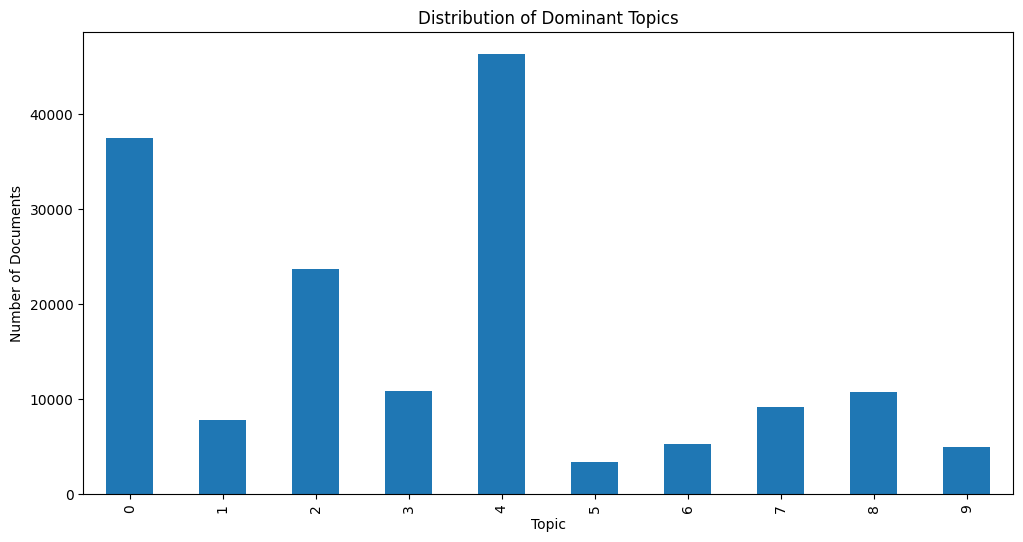

In [40]:
#Topic Modeling #30 min
!pip install pyLDAvis

import gensim
from gensim import corpora
from gensim.models import LdaMulticore
from gensim.parsing.preprocessing import STOPWORDS
import pyLDAvis.gensim_models

# Function to preprocess text for LDA
def preprocess_text(text):
    # Tokenize the text
    tokens = gensim.utils.simple_preprocess(text)
    # Remove stopwords
    return [token for token in tokens if token not in STOPWORDS]

# Preprocess the texts
processed_texts = df['Text'].apply(preprocess_text)

# Create a dictionary from the texts
dictionary = corpora.Dictionary(processed_texts)

# Create a corpus
corpus = [dictionary.doc2bow(text) for text in processed_texts]

# Set training parameters
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

# Train LDA model
model = LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    random_state=100,
    chunksize=chunksize,
    passes=passes,
    iterations=iterations,
    eval_every=eval_every
)

# Print the topics
print(model.print_topics())

# Visualize the topics
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.save_html(vis, 'lda_visualization.html')

# Function to get the dominant topic for each document
def get_dominant_topic(ldamodel, corpus, texts):
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus):
        topic_percs = ldamodel.get_document_topics(corp, minimum_probability=0)
        dominant_topic = sorted(topic_percs, key=lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append(dominant_topic)
        topic_percentages.append(topic_percs)
    return dominant_topics, topic_percentages
# Get dominant topic for each document
dominant_topics, topic_percentages = get_dominant_topic(model, corpus, processed_texts)

# Add dominant topic to the dataframe
df['dominant_topic'] = dominant_topics

# View results
print(df[['Text', 'dominant_topic', 'oh_label']].head(10))

# Analyze topic distribution
topic_counts = df['dominant_topic'].value_counts().sort_index()
print("\nTopic Distribution:")
print(topic_counts)

# Visualize topic distribution
plt.figure(figsize=(12, 6))
topic_counts.plot(kind='bar')
plt.title('Distribution of Dominant Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Documents')
plt.show()

In [41]:
df.to_csv('sentiment_and_topics.csv', index=False)

In [43]:
#Features and target

X = df['Text']
y = df['oh_label']

In [44]:
#Split dataset into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Word frequency analysis
all_words = ' '.join(X_train).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(40)

# Display the top 40 words
print("Top 40 most common words:")
for word, freq in common_words:
    print(f"{word}, {freq}")

Top 40 most common words:
the, 360570
to, 234578
of, 177152
and, 170567
a, 164045
I, 152474
you, 139484
is, 136551
allcaps, 132918
that, 119530
in, 107325
it, 89935
for, 78624
NEGnot, 71410
on, 69839
be, 66457
this, 63827
have, 56501
as, 56089
are, 54796
with, 46720
your, 44810
was, 43445
article, 43255
or, 40308
page, 35367
but, 34905
an, 34023
The, 33952
from, 32169
by, 31359
my, 31333
at, 30259
about, 29196
do, 28290
me, 27903
if, 25699
can, 24936
has, 24576
Wikipedia, 23391


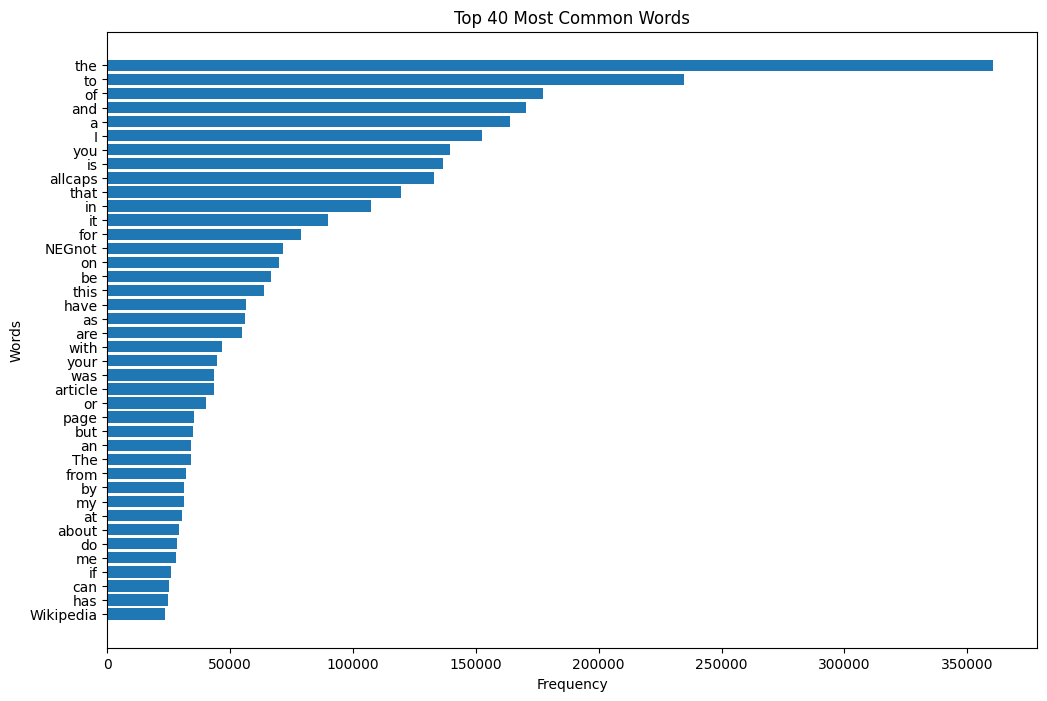

In [47]:
import matplotlib.pyplot as plt
# Plot the top 40 words

words, frequencies = zip(*common_words)
plt.figure(figsize=(12, 8))
plt.barh(words, frequencies)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 40 Most Common Words')
plt.gca().invert_yaxis()
plt.show()

In [48]:
# Define a pipeline with TF-IDF vectorizer and Logistic Regression model


pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(solver='liblinear'))
])

In [49]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'tfidf__max_df': [0.7, 0.8, 0.9, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': [0.1, 1, 10, 100]
}

In [50]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('clf',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'tfidf__max_df': [0.7, 0.8, 0.9, 1.0],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='roc_auc', verbose=1)

In [51]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

In [52]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [53]:
# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f'AUC Score: {auc_score}')


AUC Score: 0.9718769829519015


In [54]:

# Display the best parameters
print(f'Best Parameters: {grid_search.best_params_}')

Best Parameters: {'clf__C': 10, 'tfidf__max_df': 0.7, 'tfidf__ngram_range': (1, 2)}
